In [1]:
!pip install adversarial-robustness-toolbox

<ipython-input-5-864e58d16182>:26: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  x = tf.layers.conv2d(input_ph, filters=4, kernel_size=5, activation=tf.nn.relu)
<ipython-input-5-864e58d16182>:27: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  x = tf.layers.max_pooling2d(x, 2, 2)
<ipython-input-5-864e58d16182>:28: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  x = tf.layers.conv2d(x, filters=10, kernel_size=5, activation=tf.nn.relu)
<ipython-input-5-864e58d16182>:29: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  x = tf.layers.max_pooling2d(x, 2, 2)
<ipython-input-5-864e58d16182>:30: UserWarning: `tf.layers.flatten` is

Accuracy on benign test examples: 97.21%
Accuracy on adversarial test examples: 19.63%
Accuracy on benign test examples: 97.21%
Accuracy on adversarial test examples: 19.63%


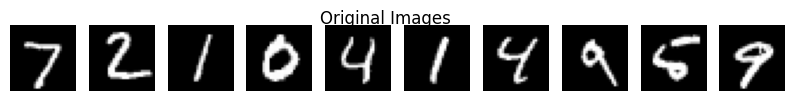

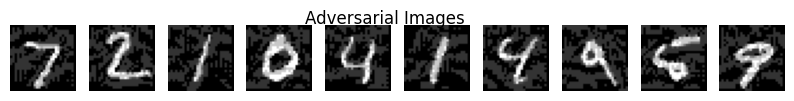

In [5]:
"""
The script demonstrates a simple example of using ART with TensorFlow v1.x. The example train a small model on the MNIST
dataset and creates adversarial examples using the Fast Gradient Sign Method. Here we use the ART classifier to train
the model, it would also be possible to provide a pretrained model to the ART classifier.
The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.
"""
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowClassifier
from art.utils import load_mnist

# Загрузка датасета MNIST

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 2: Create the model

input_ph = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
labels_ph = tf.placeholder(tf.int32, shape=[None, 10])

x = tf.layers.conv2d(input_ph, filters=4, kernel_size=5, activation=tf.nn.relu)
x = tf.layers.max_pooling2d(x, 2, 2)
x = tf.layers.conv2d(x, filters=10, kernel_size=5, activation=tf.nn.relu)
x = tf.layers.max_pooling2d(x, 2, 2)
x = tf.layers.flatten(x)
x = tf.layers.dense(x, 100, activation=tf.nn.relu)
logits = tf.layers.dense(x, 10)

loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(logits=logits, onehot_labels=labels_ph))
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train = optimizer.minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

#ART classifier

classifier = TensorFlowClassifier(
    clip_values=(min_pixel_value, max_pixel_value),
    input_ph=input_ph,
    output=logits,
    labels_ph=labels_ph,
    train=train,
    loss=loss,
    learning=None,
    sess=sess,
    preprocessing_defences=[],
)

# Обучение ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

#adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=x_test)

#ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

# Оценка на доброкачественных тестовых примерах
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

# Оценка на адверсариальных тестовых примерах
predictions_adv = classifier.predict(x_test_adv)
accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

# Визуализация нескольких изображений
def plot_images(images, title):
    plt.figure(figsize=(10, 1))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(np.squeeze(images[i]), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Отобразим несколько оригинальных и адверсариальных изображений
plot_images(x_test, title='Original Images')
plot_images(x_test_adv, title='Adversarial Images')